In [1]:
import pandas as pd

data = pd.read_csv("../../dataset/dataset_final.csv")
data

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,Target
0,-4.362150,-1.007771,-2.563540,1.331845,-1.075936,-1.368674,-0.191537,-0.373345,-0.803115,0.837092,1.623067,-0.261753,0.235638,-0.326818,Dropout
1,-0.241665,-0.291954,-1.576865,-1.195618,1.024771,0.349829,-0.015485,-0.468722,-0.327269,0.175780,-2.409748,-0.823892,-0.581045,-0.973223,Graduate
2,-2.704703,0.883059,0.227150,-0.584111,-0.216966,-0.617850,0.370419,0.055970,-1.348930,-0.152507,-2.033690,0.099927,-1.232974,-0.678305,Dropout
3,0.366266,-0.237005,0.779684,-0.273035,-0.053979,-0.070852,-0.957714,-1.342641,-0.319636,-0.506683,-0.036937,1.136352,0.300461,-0.328121,Graduate
4,0.002403,2.173728,-0.855346,1.884833,1.329653,0.679385,-0.600227,-0.520670,0.723744,0.238530,0.123345,0.951798,-0.536999,0.329798,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6622,0.060873,-1.038330,-0.659588,-0.622870,0.090081,0.225687,0.144346,-0.735628,1.092355,-0.388809,-0.191486,-0.284427,-0.311598,-0.111791,Enrolled
6623,1.148948,-1.170207,-0.717351,-0.962082,0.870401,0.614360,0.009241,-0.920165,0.642480,0.390729,-0.037445,-0.035594,-0.211604,-0.474668,Enrolled
6624,-1.002743,0.146619,1.154968,-0.141683,-1.294870,-0.938337,0.429822,-0.098083,0.023849,-0.824973,0.271648,0.682401,0.797084,0.081801,Enrolled
6625,-0.388730,1.818346,0.501319,1.047079,0.424902,0.603358,-0.964207,-1.525201,0.314041,-0.649624,0.409576,0.568857,-0.749601,-0.016070,Enrolled


In [2]:
features = data.drop(['Target'], axis = 1)

target = data['Target']
target.value_counts()

Dropout     2209
Graduate    2209
Enrolled    2209
Name: Target, dtype: int64

Splitting the dataset into training (80%), testing data (20%)


In [3]:
from sklearn.model_selection import train_test_split

#training data is 80%, test is 20%
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 42) 


#checking split
print("Total number of datapoints: "+str(features.shape[0]))
print("Number of datapoints in the training set: "+str(X_train.shape[0]))
print("Number of datapoints in the test set: "+str(X_test.shape[0]))


Total number of datapoints: 6627
Number of datapoints in the training set: 5301
Number of datapoints in the test set: 1326


**K-nearest neighbours (KNN) Algorithm**


To ensure that all features equally contribute to the computation of distances, when KNN is applied, we need to standardise them


In [4]:
from sklearn.preprocessing import StandardScaler
import numpy as np

#fit the standardscaler on the training data and use it to transform the test data
#learn the statistics from the training data - mean and stdev of the training data to scale the training and test data as well
scaler = StandardScaler()
#does the fit and transform in one step
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

for i in range(X_train.shape[1]):
  print("feature: %2d - Mean: %.1f - Std: %.3f - Min: %.3f - Max: %.3f" % (i+ 1,  np.mean(X_train[:,i]), np.std(X_train[:,i]), np.min(X_train[:,i]), np.max(X_train[:,i])))

feature:  1 - Mean: 0.0 - Std: 1.000 - Min: -2.586 - Max: 7.242
feature:  2 - Mean: 0.0 - Std: 1.000 - Min: -1.875 - Max: 6.357
feature:  3 - Mean: 0.0 - Std: 1.000 - Min: -5.676 - Max: 3.117
feature:  4 - Mean: -0.0 - Std: 1.000 - Min: -6.976 - Max: 3.505
feature:  5 - Mean: -0.0 - Std: 1.000 - Min: -5.688 - Max: 2.861
feature:  6 - Mean: -0.0 - Std: 1.000 - Min: -4.958 - Max: 12.820
feature:  7 - Mean: 0.0 - Std: 1.000 - Min: -7.851 - Max: 2.397
feature:  8 - Mean: 0.0 - Std: 1.000 - Min: -2.291 - Max: 8.747
feature:  9 - Mean: 0.0 - Std: 1.000 - Min: -6.719 - Max: 3.604
feature: 10 - Mean: -0.0 - Std: 1.000 - Min: -5.645 - Max: 6.281
feature: 11 - Mean: -0.0 - Std: 1.000 - Min: -3.528 - Max: 4.403
feature: 12 - Mean: 0.0 - Std: 1.000 - Min: -4.775 - Max: 5.211
feature: 13 - Mean: 0.0 - Std: 1.000 - Min: -3.080 - Max: 4.482
feature: 14 - Mean: -0.0 - Std: 1.000 - Min: -6.114 - Max: 5.045


Hyperparameter testing using GridSearchCV

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


param_grid = {
    'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'cosine']
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3, scoring='accuracy')

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)


Best parameters: {'metric': 'cosine', 'n_neighbors': 4, 'weights': 'distance'}
Best cross-validation score: 0.7785323523863422


Use the parameters given to train the model using the training data, and test the accuracy on the unseen test set


Classification Report for K-nn classifier with k=4, metric = cosine and weights = distance:
              precision    recall  f1-score   support

     Dropout       0.86      0.82      0.84       444
    Enrolled       0.75      0.88      0.81       439
    Graduate       0.83      0.73      0.78       443

    accuracy                           0.81      1326
   macro avg       0.81      0.81      0.81      1326
weighted avg       0.81      0.81      0.81      1326



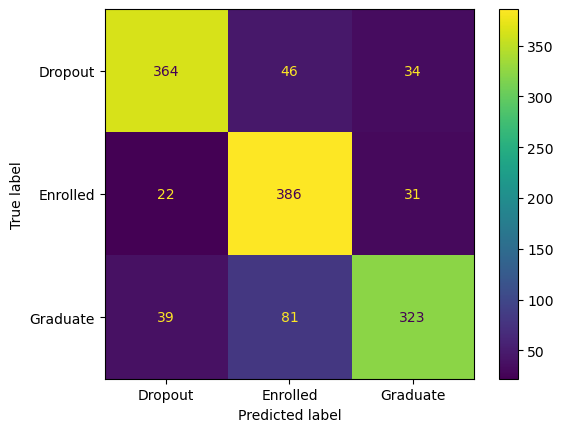

In [6]:
clf = KNeighborsClassifier(n_neighbors=4, metric='cosine', weights = 'distance')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

from sklearn.metrics import classification_report
print("\nClassification Report for K-nn classifier with k=4, metric = cosine and weights = distance:")
print(classification_report(y_test, y_pred))


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

Generate plots of the accuracies as determined in the GridSearch for each parameter

In [7]:
grid_search.best_params_

{'metric': 'cosine', 'n_neighbors': 4, 'weights': 'distance'}

In [8]:
df_results = pd.DataFrame(grid_search.cv_results_)
df_results.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003183,0.004502,0.082029,0.006280,euclidean,1,uniform,"{'metric': 'euclidean', 'n_neighbors': 1, 'wei...",0.762309,0.771364,0.782683,0.772118,0.008335,13
1,0.003257,0.004606,0.050679,0.002346,euclidean,1,distance,"{'metric': 'euclidean', 'n_neighbors': 1, 'wei...",0.762309,0.771364,0.782683,0.772118,0.008335,13
2,0.005458,0.007719,0.099818,0.000111,euclidean,2,uniform,"{'metric': 'euclidean', 'n_neighbors': 2, 'wei...",0.707980,0.709111,0.726655,0.714582,0.008550,54
3,0.000000,0.000000,0.066424,0.004648,euclidean,2,distance,"{'metric': 'euclidean', 'n_neighbors': 2, 'wei...",0.762309,0.771364,0.782683,0.772118,0.008335,13
4,0.007735,0.006873,0.109728,0.007232,euclidean,3,uniform,"{'metric': 'euclidean', 'n_neighbors': 3, 'wei...",0.702320,0.717035,0.739672,0.719676,0.015363,51


In [9]:
df_results.shape

(90, 14)

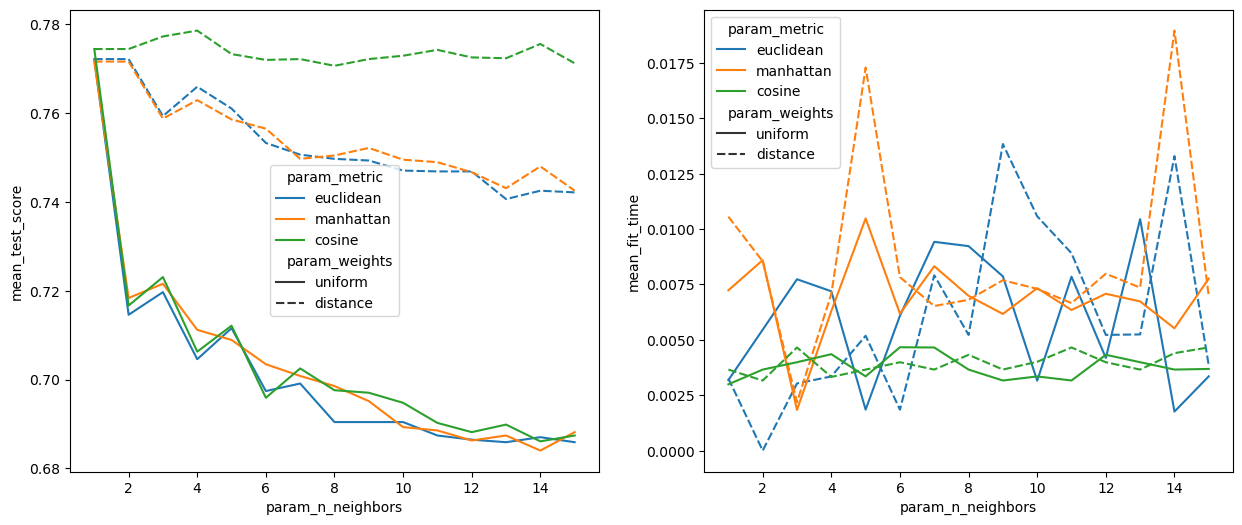

In [10]:
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.lineplot(data=df_results, x='param_n_neighbors', y='mean_test_score', hue = 'param_metric', style = 'param_weights', ax = ax[0])
sns.lineplot(data=df_results, x='param_n_neighbors', y='mean_fit_time', hue = 'param_metric', style = 'param_weights', ax = ax[1])
plt.show()
